In [1]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model


def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array.astype("float32")


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0).astype("float32")


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

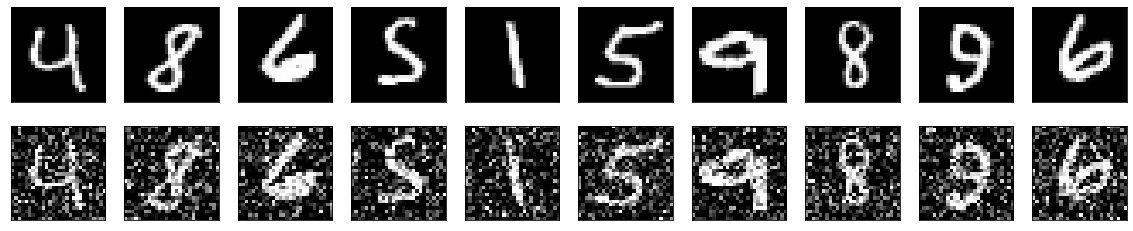

In [2]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

In [3]:
input = layers.Input(shape=(28, 28, 1), dtype=tf.float32)

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 32)       9248  

In [4]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/100
469/469 [==============================] - 6s 8ms/step - loss: 0.1743 - val_loss: 0.1049
Epoch 2/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1014 - val_loss: 0.0974
Epoch 3/100
469/469 [==============================] - 4s 7ms/step - loss: 0.0966 - val_loss: 0.0944
Epoch 4/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0943 - val_loss: 0.0926
Epoch 5/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0927 - val_loss: 0.0916
Epoch 6/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0916 - val_loss: 0.0906
Epoch 7/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0908 - val_loss: 0.0898
Epoch 8/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0901 - val_loss: 0.0892
Epoch 9/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0896 - val_loss: 0.0886
Epoch 10/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0891 - val_lo

313/313 [==============================] - 1s 1ms/step


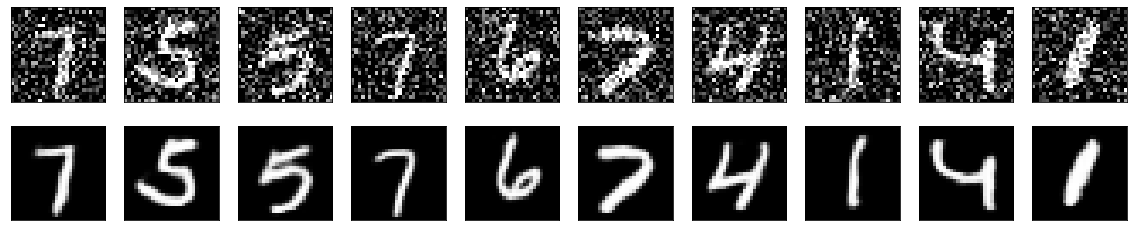

In [5]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

In [6]:
# Keras model format
autoencoder.save('autoencoder.h5')
autoencoder.load_weights('./autoencoder.h5')

In [7]:
# My own weights format for easy parsing
with open("model_weights.bin", mode='wb') as f:
    for w in autoencoder.weights:
        print(w.name, w.shape)
        if 'transpose' in w.name and 'kernel' in w.name:
            w = w[::-1, ::-1, :, :]
        w.numpy().tofile(f)

conv2d/kernel:0 (3, 3, 1, 32)
conv2d/bias:0 (32,)
conv2d_1/kernel:0 (3, 3, 32, 32)
conv2d_1/bias:0 (32,)
conv2d_transpose/kernel:0 (3, 3, 32, 32)
conv2d_transpose/bias:0 (32,)
conv2d_transpose_1/kernel:0 (3, 3, 32, 32)
conv2d_transpose_1/bias:0 (32,)
conv2d_2/kernel:0 (3, 3, 32, 1)
conv2d_2/bias:0 (1,)


In [8]:
noise_big_sample = noise(cv2.resize(test_data[0], (256, 256), interpolation = cv2.INTER_LANCZOS4)) * 255

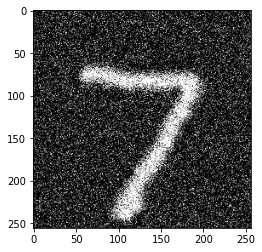

In [9]:
plt.imshow(noise_big_sample)

In [10]:
cv2.imwrite('sample256x256.png', noise_big_sample)

True

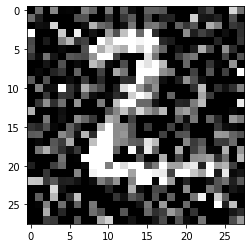

In [11]:
noise_small_sample = noise(test_data[1]) * 255
plt.imshow(noise_small_sample)

In [12]:
cv2.imwrite('sample28x28.png', noise_small_sample)

True